# Hate Speech Detector - PL - LSTM model

In [1]:
import os
import pandas as pd
import csv
import numpy as np
import pickle
from klepto.archives import dir_archive

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Concatenate
from tensorflow.keras.layers import Lambda
from tensorflow import split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## Load features & labels

In [2]:
archive = dir_archive('hsd/Poleval2019/X_y_lstm', {}, cached=True)
archive.load()

features = archive['features']
labels = archive['labels']
first_card = archive['wt_num']

In [3]:
features.shape

(11041, 40, 200)

In [4]:
first_card

13

## Model

The best model was selected using a GridSearch with 5-fold CV.

In [5]:
# hyperparams
LAYERS = 2 # convolutional layers count
LR = 0.001  # learning rate
OPTIM = tf.keras.optimizers.Adam  # optimizer
EPOCHS = 10

# params
BATCH_SIZE = 25  # size of input batch
INIT = 'random_uniform'  # trainable param initializer
RNN_UNITS = 64  # recurrent network working units

In [6]:
SPLIT_RATIO = 0.7

In [7]:
X_train = features[:int(SPLIT_RATIO*len(features))]
y_train = labels[:int(SPLIT_RATIO*len(labels))]
X_test = features[int(SPLIT_RATIO*len(features)):]
y_test = labels[int(SPLIT_RATIO*len(labels)):]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Train x: {}'.format(len(X_train)))
print('Train y: {}'.format(len(y_train)))
print('Test x: {}'.format(len(X_test)))
print('Test y: {}'.format(len(y_test)))

Train x: 7728
Train y: 7728
Test x: 3313
Test y: 3313


In [8]:
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.val_f1s0 = []
        self.val_f1s1 = []
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.asarray(tf.argmax(self.model.predict(X_test), axis=1))
        val_true = np.asarray(tf.argmax(y_test, axis=1))
        c_m = confusion_matrix(val_true, val_predict, labels=[0, 1])
        self.val_f1s0.append(2*float(c_m[0][0])/(2*float(c_m[0][0]) + c_m[0][1] + c_m[1][0]))
        self.val_f1s1.append(2*float(c_m[1][1])/(2*float(c_m[1][1]) + c_m[1][0] + c_m[0][1]))

In [9]:
class LSTMModel():
    def __init__(self, wt_card, input_shape, model_type='lstm', name='conv_model', **kwargs):
        self.wt_card = wt_card
        self.type = LSTM if model_type == 'lstm' else SimpleRNN
        
        # hyperparams
        self.layers = LAYERS if 'layers' not in kwargs else kwargs['layers']
        self.lr = LR if 'lr' not in kwargs else kwargs['lr']
        self.optim = OPTIM(learning_rate=self.lr) if 'optim' not in kwargs else kwargs['optim'](learning_rate=self.lr)
        self.epochs = EPOCHS if 'epochs' not in kwargs else kwargs['epochs']
        
        # params
        self.batch_size = BATCH_SIZE if 'batch_size' not in kwargs else kwargs['batch_size']
        self.init = INIT if 'init' not in kwargs else kwargs['init']
        self.rnn_units = RNN_UNITS if 'rnn_units' not in kwargs else kwargs['rnn_units']
        
        # layers
        inputs = Input(shape=input_shape, name='features')
        wt_inputs, pos_inputs = Lambda(lambda x: split(x, [self.wt_card, x.shape[1] - self.wt_card], axis=1), name='wt_pos_split')(inputs)
        
        x1 = self.type(units=self.rnn_units, name='wt_recurrent',
                       kernel_initializer=self.init, bias_initializer=self.init)(wt_inputs)
        x2 = self.type(units=self.rnn_units, name='pos_recurrent',
                       kernel_initializer=self.init, bias_initializer=self.init)(pos_inputs)
        
        x = Concatenate(axis=1, name='concatenation')([x1, x2])
        
        x = Dense(64, activation='relu', name='dense_1',
                  kernel_initializer='random_normal', bias_initializer='random_normal')(x)
        x = Dense(64, activation='relu', name='dense_2',
                  kernel_initializer='random_normal', bias_initializer='random_normal')(x)
        outputs = Dense(2, activation='softmax', name='predictions',
                        kernel_initializer='random_normal', bias_initializer='random_normal')(x)
        
        self.name = name
        self.model = Model(inputs=inputs, outputs=outputs, name=name)
        self.mc = MetricsCallback()
    
    def summary(self):
        return self.model.summary()
    
    def compile(self):
        self.model.compile(optimizer=self.optim,
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    def fit(self, X_tr, y_tr, X_ev, y_ev):
        return self.model.fit(X_tr, y_tr, batch_size=self.batch_size, epochs=self.epochs,
                              validation_data=(X_ev, y_ev), callbacks=[self.mc])
    
    def predict(self, X_t):
        return self.model.predict(X_t)
    
    def save(self, file_name):
        self.model.save(file_name)

In [10]:
def models_comparison_bars(df, title, save_file=None):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    
    x = range(1, len(df) + 1)
    acc = df['acc'].values
    f1s0 = df['f1s0'].values
    f1s1 = df['f1s1'].values
    
    max_acc_id = np.argmax(acc)
    max_f1s0_id = np.argmax(f1s0)
    max_f1s1_id = np.argmax(f1s1)
    
    axs[0].bar(x, acc, color='r')
    axs[0].set_xlabel('Model number')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_ylim([0, 1])
    axs[0].set_title('Accuracy | max ({}) at: {}'.format(np.round(np.max(acc), 2), max_acc_id+1))
    axs[0].patches[max_acc_id].set_facecolor('g')
    
    axs[1].bar(x, f1s0, color='b')
    axs[1].set_xlabel('Model number')
    axs[1].set_ylabel('F1 score (no hate)')
    axs[1].set_title('F1 score (no hate) | max ({}) at: {}'.format(np.round(np.max(f1s0), 2), max_f1s0_id+1))
    axs[1].set_ylim([0, 1])
    axs[1].patches[max_f1s0_id].set_facecolor('g')
    
    axs[2].bar(x, f1s1, color='m')
    axs[2].set_xlabel('Model number')
    axs[2].set_ylabel('F1 score (hate speech)')
    axs[2].set_title('F1 score (hate speech) | max ({}) at: {}'.format(np.round(np.max(f1s1), 2),
                                                                       max_f1s1_id+1))
    axs[2].set_ylim([0, 1])
    axs[2].patches[max_f1s1_id].set_facecolor('g')
    
    fig.suptitle(title)
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

## Model hyperparams researching

In [11]:
layers_options = [2, 3, 4]
lr_options = [0.1, 0.01, 0.001]
optim_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
epochs_options = [5, 10, 15]

hp_options = []
for epochs in [epochs_options[-1]]:  # changed to process 15 epochs (eval. after each 5)
    for lr in lr_options:
        for optim in optim_options:
            for layer in layers_options:
                hp_options.append({'lr': lr, 'optim': optim, 'epochs': epochs, 'layers': layer})

In [12]:
pd.DataFrame(hp_options).head()

,epochs,layers,lr,optim
0,15,2,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
1,15,3,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
2,15,4,0.1,<class 'tensorflow.python.keras.optimizer_v2.a...
3,15,2,0.1,<class 'tensorflow.python.keras.optimizer_v2.g...
4,15,3,0.1,<class 'tensorflow.python.keras.optimizer_v2.g...


In [13]:
if not os.path.exists('results/pl_lstm/hyperparams_research.csv'):
    hp_results = []
    for i, opts in enumerate(hp_options):
        print('\nResearching for {}/{} | Hyperparams: {}\n'.format(i+1, len(hp_options), opts))

        hp_model = LSTMModel(wt_card=first_card, input_shape=(40, 200, ), model_type='simple', **opts)
        hp_model.compile()
        hp_history = hp_model.fit(X_train, y_train, X_test, y_test)

        # append means for 5, 10 and 15 epochs
        for eps in epochs_options:
            hp_results.append({'acc': np.mean(hp_history.history['categorical_accuracy'][:eps]),
                               'val_acc': np.mean(hp_history.history['val_categorical_accuracy'][:eps]),
                               'loss': np.mean(hp_history.history['val_loss'][:eps]),
                               'f1s0': np.mean(hp_model.mc.val_f1s0[:eps]),
                               'f1s1': np.mean(hp_model.mc.val_f1s1[:eps])})
    
    hp_results_df = pd.DataFrame(hp_results)
    hp_results_df.to_csv('results/pl_lstm/hyperparams_research.csv')
else:
    hp_results_df = pd.read_csv('results/pl_lstm/hyperparams_research.csv', index_col=0)

In [14]:
hp_results_df.head()

,acc,f1s0,f1s1,loss,val_acc
0,0.937397,0.917143,0.0,0.491875,0.846967
1,0.937772,0.917143,0.0,0.487696,0.846967
2,0.937897,0.917143,0.0,0.485320,0.846967
3,0.936957,0.917143,0.0,0.474359,0.846967
4,0.937552,0.917143,0.0,0.471360,0.846967


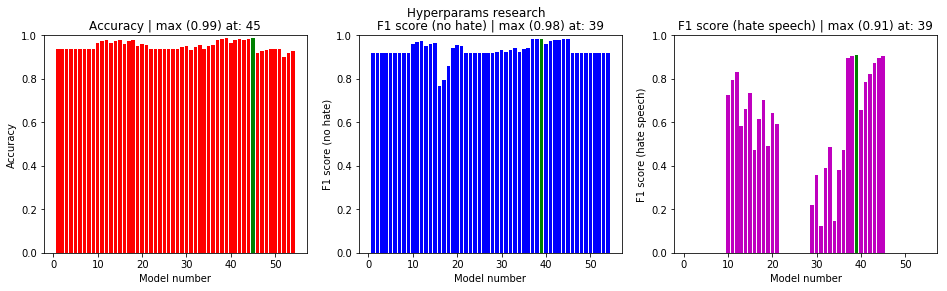

In [15]:
models_comparison_bars(hp_results_df, title='Hyperparams research', save_file='results/pl_lstm/hyperparams_research.png')

In [16]:
best_h_num = 39
'Best one: {} with {} run epochs'.format(hp_options[(best_h_num-1)/3],
                                         ((best_h_num-1)%3)*5 if (best_h_num-1)%3 != 0 else 15)

"Best one: {'optim': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'epochs': 15, 'lr': 0.001, 'layers': 2} with 10 run epochs"

## Model params researching

In [17]:
batch_size_options = [25, 50, 75, 100]
init_options = ['random_uniform', 'random_normal']
rnn_units_options = [64, 128, 192]

p_options = []
for batch_size in batch_size_options:
    for init in init_options:
        for rnn_units in rnn_units_options:
            p_options.append({'batch_size': batch_size,
                              'init': init,
                              'rnn_units': rnn_units})

In [18]:
pd.DataFrame(p_options).head()

,batch_size,init,rnn_units
0,25,random_uniform,64
1,25,random_uniform,128
2,25,random_uniform,192
3,25,random_normal,64
4,25,random_normal,128


In [19]:
if not os.path.exists('results/pl_lstm/params_research.csv'):
    p_results = []
    for i, opts in enumerate(p_options):
        print('\nResearching for {}/{} | Params: {}\n'.format(i+1, len(p_options), opts))

        p_model = LSTMModel(wt_card=first_card, input_shape=(40, 200, ), model_type='simple', **opts)
        p_model.compile()
        p_history = p_model.fit(X_train, y_train, X_test, y_test)

        p_results.append({'acc': np.mean(p_history.history['categorical_accuracy']),
                          'val_acc': np.mean(p_history.history['val_categorical_accuracy']),
                          'loss': np.mean(p_history.history['val_loss']),
                          'f1s0': np.mean(p_model.mc.val_f1s0),
                          'f1s1': np.mean(p_model.mc.val_f1s1)})
    
    p_results_df = pd.DataFrame(p_results)
    p_results_df.to_csv('results/pl_lstm/params_research.csv')
else:
    p_results_df = pd.read_csv('results/pl_lstm/params_research.csv', index_col=0)

In [20]:
p_results_df.head()

,acc,f1s0,f1s1,loss,val_acc
0,0.987668,0.985997,0.916887,0.084813,0.976034
1,0.986051,0.981272,0.879877,0.108467,0.967643
2,0.984511,0.979864,0.873935,0.125280,0.965288
3,0.987655,0.983682,0.900133,0.083880,0.971959
4,0.984718,0.983216,0.897805,0.091621,0.971174


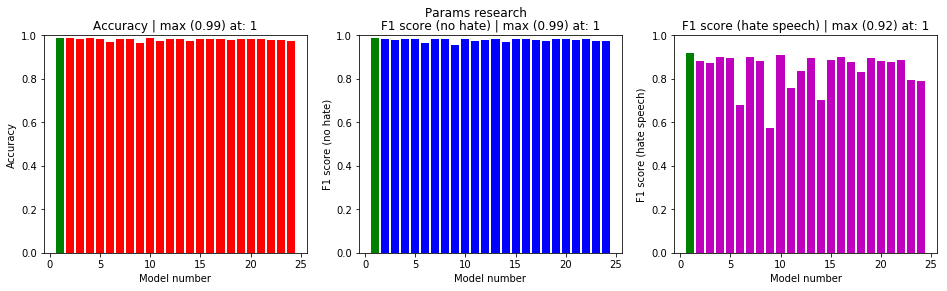

In [21]:
models_comparison_bars(p_results_df, title='Params research', save_file='results/pl_lstm/params_research.png')

In [22]:
best_num = 1
'Best one: {}'.format(p_options[best_num-1])

"Best one: {'init': 'random_uniform', 'batch_size': 25, 'rnn_units': 64}"

## Best model

In [23]:
model = LSTMModel(wt_card=first_card, input_shape=(40, 200, ))
model.summary()

Model: "conv_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 40, 200)]    0                                            
__________________________________________________________________________________________________
wt_pos_split (Lambda)           [(None, 13, 200), (N 0           features[0][0]                   
__________________________________________________________________________________________________
wt_recurrent (LSTM)             (None, 64)           67840       wt_pos_split[0][0]               
__________________________________________________________________________________________________
pos_recurrent (LSTM)            (None, 64)           67840       wt_pos_split[0][1]               
_________________________________________________________________________________________

In [24]:
model.compile()
history = model.fit(X_train, y_train, X_test, y_test)
#model.save('models/pl_lstm.model')

Train on 7728 samples, validate on 3313 samples
Epoch 1/10
7728/7728 [==============================] - 50s 6ms/sample - loss: 0.1202 - categorical_accuracy: 0.9626 - val_loss: 0.0937 - val_categorical_accuracy: 0.9722
Epoch 2/10
7728/7728 [==============================] - 19s 3ms/sample - loss: 0.0317 - categorical_accuracy: 0.9885 - val_loss: 0.0769 - val_categorical_accuracy: 0.9765
Epoch 3/10
7728/7728 [==============================] - 20s 3ms/sample - loss: 0.0257 - categorical_accuracy: 0.9903 - val_loss: 0.0772 - val_categorical_accuracy: 0.9765
Epoch 4/10
7728/7728 [==============================] - 20s 3ms/sample - loss: 0.0244 - categorical_accuracy: 0.9912 - val_loss: 0.0797 - val_categorical_accuracy: 0.9792
Epoch 5/10
7728/7728 [==============================] - 20s 3ms/sample - loss: 0.0225 - categorical_accuracy: 0.9915 - val_loss: 0.0691 - val_categorical_accuracy: 0.9834
Epoch 6/10
7728/7728 [==============================] - 21s 3ms/sample - loss: 0.0222 - categoric

In [25]:
predictions = model.predict(X_test)
y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(predictions, axis=1)

conf_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred, num_classes=2).numpy()
acc = float(np.sum(np.diag(conf_mat)))/np.sum(np.sum(conf_mat))

In [26]:
# save model history, confusion matrix and accuracy
model_results = {'acc': history.history['categorical_accuracy'],
                 'val_acc': history.history['val_categorical_accuracy'],
                 'loss': history.history['loss'],
                 'val_loss': history.history['val_loss'],
                 'f1s0': model.mc.val_f1s0,
                 'f1s1': model.mc.val_f1s1,
                 'conf_mat': conf_mat,
                 'main_acc': acc}
with open('models/pl_lstm_results.pkl', 'w') as f:
    pickle.dump(model_results, f)

## Visualizations

In [27]:
def plots(y_ss, y_labels, colors, title, file_name=None):
    x_s = range(1, len(y_ss[0])+1)
    for y_s, y_label, color in zip(y_ss, y_labels, colors):
        plt.plot(x_s, y_s, color, label=y_label)
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    tick_marks = np.arange(1, len(x_s) + 1)
    plt.xticks(tick_marks, x_s)
    plt.title(title)
    
    plt.legend(loc='best', frameon=False)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def twinx_plot(y11_s, y12_s, y21_s, y22_s, x_label, y1_label,y2_label, title,
               styles=['r-', 'r--', 'b-', 'b--'], colors=['r', 'b'], file_name=None):
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel(x_label)
    ax1.set_xticks(range(1, len(y11_s)+1))
    
    ax1.set_ylabel(y1_label, color=colors[0])
    ax1.plot(range(1, len(y11_s)+1), y11_s, styles[0], label='train acc.')
    ax1.plot(range(1, len(y12_s)+1), y12_s, styles[1], label='valid. acc.')
    ax1.tick_params(axis='y', labelcolor=colors[0])
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel(y2_label, color=colors[1])  # we already handled the x-label with ax1
    ax2.plot(range(1, len(y21_s)+1), y21_s, styles[2], label='train loss')
    ax2.plot(range(1, len(y22_s)+1), y22_s, styles[3], label='valid. loss')
    ax2.tick_params(axis='y', labelcolor=colors[1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend(loc='right', bbox_to_anchor=(0.85, 0.5))
    plt.title(title)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def class_distribution_hist(y_true, y_pred, cls, x_label, y_label, title, file_name=None):
    pd.Series([y_true, y_pred]).hist()
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.xticks(tick_marks, cls)
    plt.legend(labels=['Real', 'Predicted'], loc='best')
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [28]:
classes = ['no hate', 'hate speech']

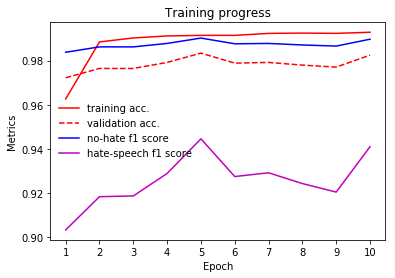

In [29]:
plots([history.history['categorical_accuracy'],
       history.history['val_categorical_accuracy'],
       model.mc.val_f1s0,
       model.mc.val_f1s1],
      ['training acc.', 'validation acc.', 'no-hate f1 score', 'hate-speech f1 score'],
      ['-r', '--r', 'b', 'm'],
      title='Training progress', file_name='results/pl_lstm/train_progress.png')

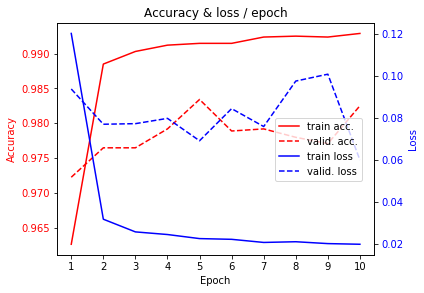

In [30]:
twinx_plot(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
           history.history['loss'], history.history['val_loss'],
          x_label='Epoch', y1_label='Accuracy', y2_label='Loss', title='Accuracy & loss / epoch',
          file_name='results/pl_lstm/acc_loss.png')

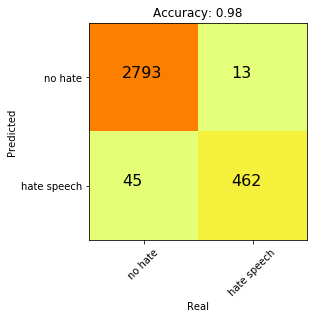

In [31]:
confusion_matrix_plot(conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Accuracy: {}'.format(round(acc, 2)),
                      file_name='results/pl_lstm/cm.png')

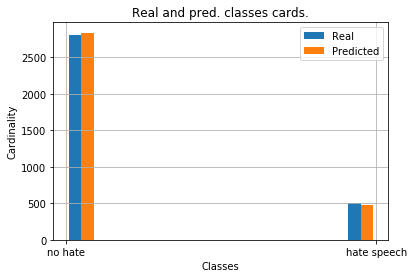

In [32]:
class_distribution_hist(y_true, y_pred, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='Real and pred. classes cards.',
                        file_name='results/pl_lstm/cards.png')